In [1]:
import os
import random
import time
import copy
from tqdm.notebook import tqdm
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms,models
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from efficientnet_pytorch import EfficientNet

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.get_device_name(torch.cuda.current_device()))

cuda:0
Tesla V100-SXM2-32GB


In [2]:
train_df = pd.read_csv("../input/data/train/labeling_train.csv")
# test_image_path = glob('../input/data/eval/images/*')
train_df = train_df.sort_values("id")

In [3]:
train_df["age_group"] = train_df["age"].apply(lambda x: 0 if x < 30 else 1 if 30 <= x < 58 else 2)
train_df["label"] = train_df["mask"]*6 + train_df["gender"]*3 + train_df["age_group"]

In [4]:
train_df[train_df["age"] >= 58]

,id,gender,race,age,age_group,mask,image_path,label
13776,000005,1,Asian,58,2,1,../input/data/train/images/000005_female_Asian...,11
13782,000005,1,Asian,58,2,0,../input/data/train/images/000005_female_Asian...,5
13777,000005,1,Asian,58,2,0,../input/data/train/images/000005_female_Asian...,5
13781,000005,1,Asian,58,2,0,../input/data/train/images/000005_female_Asian...,5
13780,000005,1,Asian,58,2,0,../input/data/train/images/000005_female_Asian...,5
...,...,...,...,...,...,...,...,...
10661,005515,1,Asian,60,2,1,../input/data/train/images/005515_female_Asian...,11
10662,005515,1,Asian,60,2,0,../input/data/train/images/005515_female_Asian...,5
10663,005515,1,Asian,60,2,2,../input/data/train/images/005515_female_Asian...,17
10667,005515,1,Asian,60,2,0,../input/data/train/images/005515_female_Asian...,5


In [108]:
# new_train_df = pd.read_csv("../input/data/train/augmentation.csv")

### Dataset, Data Loader

In [5]:
transform = transforms.Compose([
    transforms.Resize((512, 384), Image.BILINEAR),
    transforms.CenterCrop((320,256)),
    transforms.ColorJitter(0.3,0.3,0.3,0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

In [6]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_df["id"], train_df["label"])):
    train_split = train_df.loc[train_idx].reset_index(drop=True)
    eval_split = train_df.loc[val_idx].reset_index(drop=True)

In [80]:
# from sklearn.model_selection import train_test_split
# train_split, eval_split = train_test_split(new_train_df, test_size=0.2, shuffle=False,random_state=42)

# train_split.reset_index(drop=True,inplace=True)
# eval_split.reset_index(drop=True,inplace=True)

In [7]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.X = dataframe["image_path"]
        self.y = dataframe["label"]
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.X.iloc[index])
        label = self.y.iloc[index]

        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)

    def __len__(self):
        return len(self.X)

In [8]:
train_data = CustomDataset(train_split,transform)
eval_data = CustomDataset(eval_split,transform)

In [106]:
# train_data = CustomDataset(train_df,transform)

In [107]:
# train_dataloader = torch.utils.data.DataLoader(train_data,batch_size=128,shuffle=True,num_workers=1)

In [108]:
# train_size = int(0.8 * len(train_data))
# eval_size = len(train_data) - train_size
# train, eval = torch.utils.data.random_split(train_data, [train_size, eval_size])
# len(train), len(eval)

In [9]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True, num_workers=1)
eval_dataloader = torch.utils.data.DataLoader(eval_data, batch_size=256, shuffle=True, num_workers=1)

In [ ]:
for data in train_dataloader:
    images,labels = data
    plt.imshow(torchvision.utils.make_grid(images,nrow=10,normalize=True).permute(1,2,0))
    plt.show()
    break

### Model

In [10]:
# pretrained model 불러오기
model = torchvision.models.resnet18(pretrained=True)

In [11]:
num_classes = 18 # 데이터에 맞게 class 개수 변경
fc_input = model.fc.in_features # fc layer의 input 수
model.fc = nn.Linear(fc_input, num_classes) # fc layer 입출력 변경

torch.nn.init.kaiming_uniform_(model.fc.weight) # he init으로 fc layer weight, bias 초기화
stdv = 1/(fc_input**(1/2)) 
model.fc.bias.data.uniform_(-stdv,stdv)

model.to(device) # GPU에 올리기

dataloaders = {
    "train" : train_dataloader,
    "test" : eval_dataloader
}

In [12]:
# Loss
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9,weight_decay=0.0005)

# learning rate
from torch.optim import lr_scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 10

### Train

In [13]:
def train_model(model, dataloaders,criterion,optimizer,scheduler,num_epochs):
    start_time = time.time()
    max_accuracy = 0
    min_loss = int(1e9)
    early_stop_point = 0 
    early_stop_limit = 2
    stop_epoch = True
    best_model_wts = copy.deepcopy(model.state_dict())
    history = {"train_loss":[],"train_acc":[],"test_loss":[],"test_acc":[]}
    
    
    for epoch in range(num_epochs):
        f1_list = []
        for phase in ['train', 'test']:
                if phase == 'train':
                    model.train() 
                else:
                    model.eval()   

                running_loss = 0.0
                running_acc = 0.0
                
                # 데이터 반복
                for step, (inputs, labels) in enumerate(tqdm(dataloaders[phase])):
                    inputs, labels = inputs.to(device), labels.to(device)

                    # 매개변수 경사도 0으로 초기화
                    optimizer.zero_grad()

                    # 순전파
                    # train에서만 연산 기록 추적
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
        
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                        
                    running_loss += loss.item() * inputs.size(0)
                    running_acc += torch.sum(preds == labels.data)
                    f1_list.append(f1_score(labels.cpu(),preds.cpu(),average="macro"))
                    
                if phase == "train":
                    scheduler.step()

                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_acc / len(dataloaders[phase].dataset)
                
                print(f"[Epoch : %d] [Phase : %s] epoch_loss : %.5f epoch_acc: %.2f" % 
                      (epoch+1, phase, epoch_loss, epoch_acc))
                
                if phase == "train":
                    history["train_loss"].append(epoch_loss)
                    history["train_acc"].append(epoch_acc)
                else:
                    history["test_loss"].append(epoch_loss)
                    history["test_acc"].append(epoch_acc)
                            
                if phase == "test" and max_accuracy <= epoch_acc:
                    max_accuracy = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stop_point = 0
#                     for g in optimizer.param_groups:
#                             g['lr']/=10
                    
                    
                elif phase == "test" and max_accuracy > epoch_acc:
                    early_stop_point += 1
                    
                if phase == "test" and min_loss > epoch_loss:
                    min_loss = epoch_loss
                    
                if early_stop_point == early_stop_limit:
                    print("early_stopped")
                    stop_epoch = False
                    break
                
        print(f"[Epoch : %d] [Phase : %s] f1_score : %.5f" % 
                      (epoch+1, phase, np.sum(f1_list) / len(f1_list)))
        if stop_epoch == False:
            break
    print(time.time()-start_time)
    model.load_state_dict(best_model_wts)
    print("Done")
    return model,history

In [15]:
model_ft,history = train_model(model, dataloaders,criterion, optimizer, scheduler,num_epochs)


[Epoch : 1] [Phase : train] epoch_loss : 0.31881 epoch_acc: 0.88



[Epoch : 1] [Phase : test] epoch_loss : 0.31406 epoch_acc: 0.88
[Epoch : 1] [Phase : test] f1_score : 0.78319



[Epoch : 2] [Phase : train] epoch_loss : 0.19783 epoch_acc: 0.93



[Epoch : 2] [Phase : test] epoch_loss : 0.24105 epoch_acc: 0.91
[Epoch : 2] [Phase : test] f1_score : 0.85395



[Epoch : 3] [Phase : train] epoch_loss : 0.11909 epoch_acc: 0.96



[Epoch : 3] [Phase : test] epoch_loss : 0.19060 epoch_acc: 0.93
[Epoch : 3] [Phase : test] f1_score : 0.91275



[Epoch : 4] [Phase : train] epoch_loss : 0.05494 epoch_acc: 0.99



[Epoch : 4] [Phase : test] epoch_loss : 0.16531 epoch_acc: 0.94
[Epoch : 4] [Phase : test] f1_score : 0.96156



[Epoch : 5] [Phase : train] epoch_loss : 0.04708 epoch_acc: 0.99



[Epoch : 5] [Phase : test] epoch_loss : 0.15780 epoch_acc: 0.94
[Epoch : 5] [Phase : test] f1_score : 0.96538



[Epoch : 6] [Phase : train] epoch_loss : 0.04200 epoch_acc: 0.99



[Epoch : 6] [Phase : test] epoch_loss : 0.15542 epoch_acc: 0.94
[Epoch : 6] [Phase : test] f1_score : 0.96602



[Epoch : 7] [Phase : train] epoch_loss : 0.03790 epoch_acc: 1.00



[Epoch : 7] [Phase : test] epoch_loss : 0.15480 epoch_acc: 0.95
[Epoch : 7] [Phase : test] f1_score : 0.96823



[Epoch : 8] [Phase : train] epoch_loss : 0.03803 epoch_acc: 1.00



[Epoch : 8] [Phase : test] epoch_loss : 0.15932 epoch_acc: 0.94
[Epoch : 8] [Phase : test] f1_score : 0.96925



[Epoch : 9] [Phase : train] epoch_loss : 0.03701 epoch_acc: 1.00



[Epoch : 9] [Phase : test] epoch_loss : 0.15526 epoch_acc: 0.94
early_stopped
[Epoch : 9] [Phase : test] f1_score : 0.96781
2620.1849372386932
Done


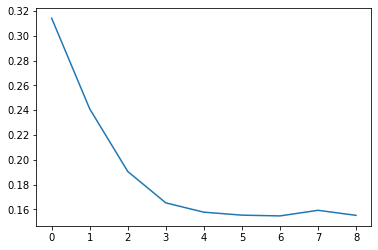

In [16]:
plt.plot(history["test_loss"])

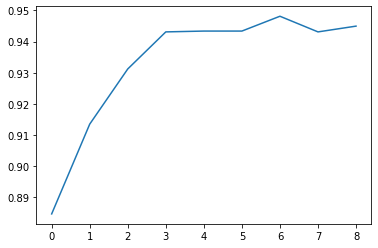

In [17]:
plt.plot(history["test_acc"])

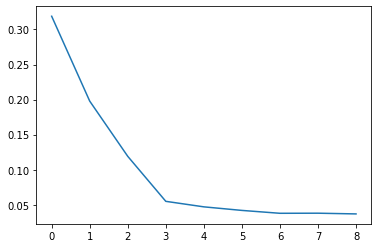

In [18]:
plt.plot(history["train_loss"])

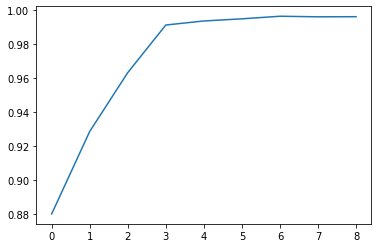

In [19]:
plt.plot(history["train_acc"])

### 이미지 출력

In [1]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# # 학습 데이터의 배치를 얻습니다.
# inputs, classes = next(iter(dataloaders['train']))

# # 배치로부터 격자 형태의 이미지를 만듭니다.
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[x for x in classes])

In [26]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    wrong_answer = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(eval_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_ft(inputs)
            _, preds = torch.max(outputs, 1)
            
#             wrong_answer.append(eval_size[i],preds.cpu().numpy()[0], labels.cpu().numpy()[0])
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('label : {},predicted: {}'.format(labels[j],preds[j]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

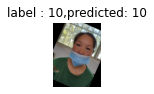

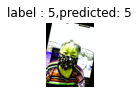

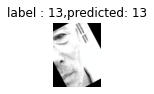

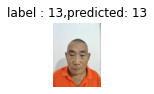

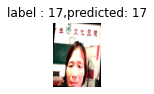

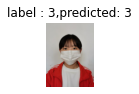

In [27]:
visualize_model(model_ft,6)

### 학습 결과 검증

In [20]:
valid_dataloader = DataLoader(eval_data,shuffle=False)

In [21]:
def wrong_data(model):
    wrong_pred = []

    with torch.no_grad():
        model.eval()
        for i, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            
            wrong_pred.append([eval_split.iloc[i]["image_path"],labels.cpu().numpy()[0],preds.cpu().numpy()[0]])
    wrong_pred = pd.DataFrame(wrong_pred, columns=["image_path","label","pred"])
    return wrong_pred

In [22]:
ee = wrong_data(model_ft)

In [23]:
from sklearn.metrics import f1_score
print(f1_score(ee["label"],ee["pred"],average="macro"))

0.90348761170967


In [133]:
wrong_answer = ee[ee["label"] != ee["pred"]]

In [134]:
wrong_answer.reset_index(drop=True,inplace=True)

In [135]:
wrong_answer

,image_path,label,pred
0,../input/data/train/images/000038_female_Asian...,11,10
1,../input/data/train/images/003535_male_Asian_5...,7,8
2,../input/data/train/images/003535_male_Asian_5...,1,2
3,../input/data/train/images/000378_female_Asian...,4,5
4,../input/data/train/images/004313_female_Asian...,4,5
...,...,...,...
245,../input/data/train/images/005004_female_Asian...,16,15
246,../input/data/train/images/004417_female_Asian...,9,3
247,../input/data/train/images/000664_male_Asian_5...,13,17
248,../input/data/train/images/000767_male_Asian_5...,1,4


In [ ]:
import matplotlib.image as img


for i in range(8):
    plt.subplot(3,3,i+1)
    image = img.imread(wrong_answer["image_path"][i])
    plt.title((wrong_answer["label"][i],wrong_answer["pred"][i]),fontsize=10)
    plt.axis('off')
    plt.imshow(image)

### Inference

In [137]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [138]:
submission = pd.read_csv("../input/data/eval/info.csv")
image_paths = [os.path.join("../input/data/eval/images",img_id) for img_id in submission.ImageID]

test_data = TestDataset(image_paths,transform)
test_dataloader = torch.utils.data.DataLoader(test_data,batch_size=128, shuffle=False)

all_predictions = []
for images in test_dataloader:
    with torch.no_grad():
        images = images.to(device)
        pred = model_ft(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

In [ ]:
import matplotlib.image as img
plt.figure(figsize=(15,15))

for i in range(8):
    plt.subplot(2,4,i+1)
    image = img.imread(os.path.join("../input/data/eval/images",submission["ImageID"][i]))
    plt.title(submission["ans"][i],fontsize=20)
    plt.axis('off')
    plt.imshow(image)

In [141]:
# 제출할 파일을 저장합니다.
submission.to_csv('../input/data/eval/submission8.csv', index=False)
print('test inference is done!')

test inference is done!


In [224]:
torch.save(model_ff.state_dict(),"./resnet2.pt")